In [1]:
%matplotlib widget

import torch
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

# Reference system and goals
We'll use the Lorenz attractor with $\sigma$, $\rho$, and $\beta$ as parameters.  Typical parameter values are $\sigma=10$, $\rho=28$, and $\beta=8/3$.

$\frac{dx}{dt}=\sigma(y-x)$

$\frac{dy}{dt}=x(\rho-z)-y$

$\frac{dz}{dt}=xy-\beta z$

We will just be able to observe $z$, and the goal will be to estimate $x,y$ and all the parameters.  The idea will be to do this with pytorch function graphs, automatic differentiation and all the goodies developed for neural (aka black box) model parameter estimation.

In [2]:
def f(t, ys, p):
    sigma, rho, beta = p
    x, y, z = ys
    dx = sigma*(y-x)
    dy = x*(rho-z)-y
    dz = x*y-beta*z
    return [dx, dy, dz]

In [45]:
r = ode(f).set_integrator('lsoda',method='bdf')
y0 = np.array([-10, -10., 25.])
t0 = 0.0

r.set_initial_value(y0,t0)
r.set_f_params([10., 28., 8./3])
t1=50
dt=0.02

In [46]:
ys = [y0]
ts = [t0]
while r.successful() and r.t < t1:
    ts.append(r.t+dt)
    ys.append(r.integrate(r.t+dt))
ts = np.array(ts)
ys = np.array(ys)

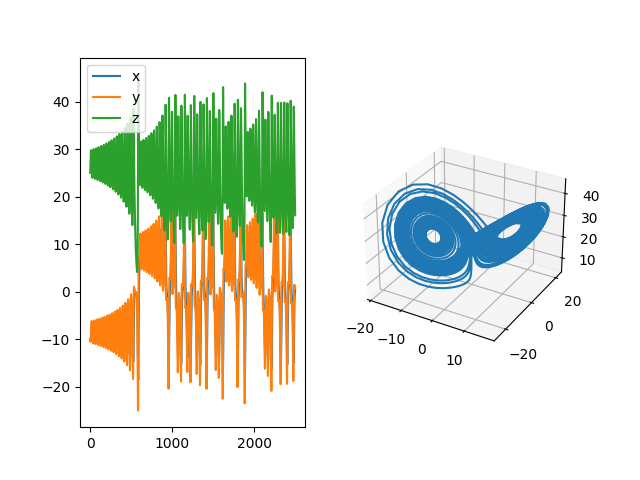

In [47]:
figure = plt.figure()
ax = plt.subplot(121)
ax.plot(ys[:,0],label='x')
ax.plot(ys[:,1],label='y')
ax.plot(ys[:,2],label='z')
ax.legend()

ax2 = plt.subplot(122, projection='3d')
ax2.plot(*ys.T)
plt.show()

In [48]:
ny=ys.shape[0]-10
ov=2  # observable variable
y=torch.randn(ny,3,requires_grad=True)
with torch.no_grad():
    y=y*20
y.requires_grad_(True)
# y[0,:]=torch.from_numpy(y0)
sigma=torch.ones(1)#*10.
rho=torch.ones(1)#*28.
beta=torch.ones(1)#*8./3.
sigma.requires_grad_(True)
rho.requires_grad_(True)
beta.requires_grad_(True)
# ml=torch.randn(9,3,requires_grad=True)
obs = torch.from_numpy(ys[1:ny,:]).type(torch.float32)
#params = (y, sigma, rho, beta)

In [49]:
for k in range(10000):
    # model loss terms, essentially an euler integrator
    mlx = y[1:,0]-(y[:-1,0]+dt*sigma*(y[:-1,1]-y[:-1,0]))
    mly = y[1:,1]-(y[:-1,1]+dt*(y[:-1,0]*(rho-y[:-1,2])-y[:-1,1]))
    mlz = y[1:,2]-(y[:-1,2]+dt*(y[:-1,0]*y[:-1,1]-beta*y[:-1,2]))
    ml = torch.vstack((mlx,mly,mlz))  #model loss
    mlz = torch.zeros_like(ml)
    mloss = torch.nn.functional.mse_loss(ml,mlz)
    
    z=y[1:,:]
    oloss = torch.nn.functional.mse_loss(z,obs) #observational loss
    loss = oloss + mloss
    loss.backward()
    if not k%1000:
        print(oloss, mloss)
    with torch.no_grad():
        y = y - y.grad.data*np.sqrt(k+1)
        sigma = sigma - sigma.grad.data
        rho = rho - rho.grad.data
        beta = beta - beta.grad.data
        #if not k%1000:
            #y = y + torch.randn_like(y)*2.
            #pass
        y[0,:]=torch.from_numpy(y0)
    y.requires_grad_(True)
    sigma.requires_grad_(True)
    beta.requires_grad_(True)
    rho.requires_grad_(True)
    #[p.requires_grad_(True) for p in params]
    
ynp = y.detach().numpy()
print(sigma, beta, rho)

tensor(667.9758, grad_fn=<MseLossBackward0>) tensor(815.9862, grad_fn=<MseLossBackward0>)
tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.0321, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0228, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor([9.8991], requires_grad=True) tensor([2.7455], requires_grad=True) tensor([27.7449], requires_grad=True)


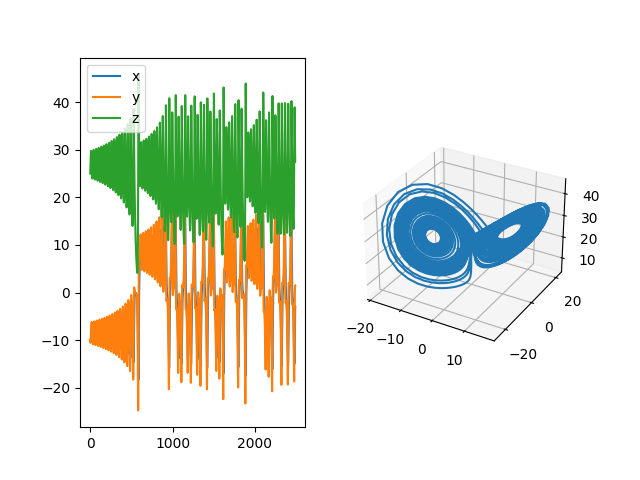

In [50]:
figure = plt.figure()
ax = plt.subplot(121)
ax.plot(ynp[:,0],label='x')
ax.plot(ynp[:,1],label='y')
ax.plot(ynp[:,2],label='z')
ax.legend()

ax2 = plt.subplot(122, projection='3d')
ax2.plot(*ynp.T)
plt.show()

In [86]:
sigma

tensor([20.0853], requires_grad=True)

In [54]:
[p.requires_grad for p in params]

[True, True, True, True]

In [41]:
ys.shape[0]

1502